# Meta-Learner Fusion Training
## Advanced Stacking Ensemble with Cross-Validation and Threshold Optimization

**Objective:** Create optimized meta-learner that fuses ML and DL predictions

**Steps:**
1. Load all trained models (5 ML + 5 DL)
2. Generate base model predictions
3. Save predictions: `p_ml.npy`, `p_dl.npy`
4. Design meta-learner architecture
5. Train with cross-validation
6. Optimize decision threshold
7. Hyperparameter tuning
8. Final evaluation and deployment

---

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import joblib
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve, classification_report
)

# DL Libraries
import tensorflow as tf
from tensorflow import keras

# Import model libraries for loading
import xgboost as xgb
import catboost

# Utils
import os
import json
from datetime import datetime

print("✓ All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ All libraries imported successfully
TensorFlow version: 2.18.1
Started at: 2025-10-09 13:47:12


## Step 2: Load Datasets

In [2]:
print("="*80)
print("LOADING DATASETS")
print("="*80)

data_dir = '../../data/final_processed_data'

# Load validation set (for meta-learner training)
print("\n1. Loading Validation Set (for meta-learner training)...")
X_val = pd.read_csv(f'{data_dir}/X_val_scaled.csv')
y_val = pd.read_csv(f'{data_dir}/y_val.csv').values.ravel()
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val.shape}")

# Load test set (for final evaluation)
print("\n2. Loading Test Set (for final evaluation)...")
X_test = pd.read_csv(f'{data_dir}/X_test_scaled.csv')
y_test = pd.read_csv(f'{data_dir}/y_test.csv').values.ravel()
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")

print(f"\n✓ Datasets loaded successfully")
print(f"\nClass Distribution:")
print(f"  Validation - Normal: {(y_val==0).sum():,} ({(y_val==0).sum()/len(y_val)*100:.2f}%), Fraud: {(y_val==1).sum():,} ({(y_val==1).sum()/len(y_val)*100:.2f}%)")
print(f"  Test       - Normal: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.2f}%), Fraud: {(y_test==1).sum():,} ({(y_test==1).sum()/len(y_test)*100:.2f}%)")

LOADING DATASETS

1. Loading Validation Set (for meta-learner training)...
   X_val: (12063, 92)
   y_val: (12063,)

2. Loading Test Set (for final evaluation)...
   X_test: (12064, 92)
   y_test: (12064,)

✓ Datasets loaded successfully

Class Distribution:
  Validation - Normal: 10,471 (86.80%), Fraud: 1,592 (13.20%)
  Test       - Normal: 10,471 (86.80%), Fraud: 1,593 (13.20%)


## Step 3: Load All Trained Models

### 3.1 Load ML Models

In [3]:
print("\n" + "="*80)
print("LOADING MACHINE LEARNING MODELS")
print("="*80)

ml_models_dir = '../ml/saved_models'
ml_models = {}

ml_model_files = [
    ('Logistic Regression', 'logistic_regression_model.pkl'),
    ('Random Forest', 'random_forest_model.pkl'),
    ('XGBoost', 'xgboost_model.pkl'),
    ('XGBoost SMOTE', 'xgboost_smote_model.pkl'),
    ('CatBoost', 'catboost_model.pkl')
]

print("\nLoading ML models...")
for model_name, filename in ml_model_files:
    filepath = os.path.join(ml_models_dir, filename)
    if os.path.exists(filepath):
        ml_models[model_name] = joblib.load(filepath)
        print(f"  ✓ Loaded: {model_name}")
    else:
        print(f"  ✗ Not found: {model_name}")

print(f"\n✓ Total ML models loaded: {len(ml_models)}")


LOADING MACHINE LEARNING MODELS

Loading ML models...
  ✓ Loaded: Logistic Regression
  ✓ Loaded: Random Forest
  ✓ Loaded: XGBoost
  ✓ Loaded: XGBoost SMOTE
  ✓ Loaded: CatBoost

✓ Total ML models loaded: 5


### 3.2 Load DL Models

In [4]:
print("\n" + "="*80)
print("LOADING DEEP LEARNING MODELS")
print("="*80)

dl_models_dir = '../dl/saved_models'
dl_models = {}

dl_model_files = [
    ('FNN', 'fnn_model.keras'),
    ('CNN', 'cnn_model.keras'),
    ('LSTM', 'lstm_model.keras'),
    ('BiLSTM', 'bilstm_model.keras'),
    ('CNN-BiLSTM', 'cnn_bilstm_model.keras')
]

print("\nLoading DL models...")
for model_name, filename in dl_model_files:
    filepath = os.path.join(dl_models_dir, filename)
    if os.path.exists(filepath):
        dl_models[model_name] = keras.models.load_model(filepath)
        print(f"  ✓ Loaded: {model_name}")
    else:
        print(f"  ✗ Not found: {model_name}")

print(f"\n✓ Total DL models loaded: {len(dl_models)}")
print(f"\n✓ TOTAL BASE MODELS: {len(ml_models) + len(dl_models)}")


LOADING DEEP LEARNING MODELS

Loading DL models...
  ✓ Loaded: FNN
  ✓ Loaded: CNN
  ✓ Loaded: LSTM
  ✓ Loaded: BiLSTM
  ✓ Loaded: CNN-BiLSTM

✓ Total DL models loaded: 5

✓ TOTAL BASE MODELS: 10


## Step 4: Generate Base Model Predictions

In [5]:
print("\n" + "="*80)
print("GENERATING BASE MODEL PREDICTIONS")
print("="*80)

# Helper function for ML predictions
def get_ml_predictions(models, X):
    """Get probability predictions from ML models"""
    predictions = []
    model_names = []
    
    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            pred_proba = model.predict_proba(X)[:, 1]
        else:
            pred_proba = model.predict(X)
        predictions.append(pred_proba)
        model_names.append(name)
    
    return np.column_stack(predictions), model_names

# Helper function for DL predictions
def get_dl_predictions(models, X):
    """Get probability predictions from DL models"""
    predictions = []
    model_names = []
    
    X_array = X.values if isinstance(X, pd.DataFrame) else X
    
    for name, model in models.items():
        # Reshape for CNN/LSTM models
        if 'CNN' in name or 'LSTM' in name or 'BiLSTM' in name:
            X_input = X_array.reshape(X_array.shape[0], X_array.shape[1], 1)
        else:
            X_input = X_array
        
        pred_proba = model.predict(X_input, verbose=0).flatten()
        predictions.append(pred_proba)
        model_names.append(name)
    
    return np.column_stack(predictions), model_names

print("\n1. Generating VALIDATION SET predictions...")
print("-" * 80)

# ML predictions (validation)
p_ml_val, ml_names = get_ml_predictions(ml_models, X_val)
print(f"\nML Predictions:")
print(f"  Shape: {p_ml_val.shape}")
print(f"  Models: {ml_names}")

# DL predictions (validation)
p_dl_val, dl_names = get_dl_predictions(dl_models, X_val)
print(f"\nDL Predictions:")
print(f"  Shape: {p_dl_val.shape}")
print(f"  Models: {dl_names}")

# Combined predictions (validation)
p_all_val = np.column_stack([p_ml_val, p_dl_val])
all_model_names = ml_names + dl_names
print(f"\nCombined Predictions:")
print(f"  Shape: {p_all_val.shape}")
print(f"  Total models: {len(all_model_names)}")

print("\n" + "-" * 80)
print("2. Generating TEST SET predictions...")
print("-" * 80)

# ML predictions (test)
p_ml_test, _ = get_ml_predictions(ml_models, X_test)
print(f"\nML Predictions: {p_ml_test.shape}")

# DL predictions (test)
p_dl_test, _ = get_dl_predictions(dl_models, X_test)
print(f"DL Predictions: {p_dl_test.shape}")

# Combined predictions (test)
p_all_test = np.column_stack([p_ml_test, p_dl_test])
print(f"Combined Predictions: {p_all_test.shape}")

print("\n" + "="*80)
print("✓ PREDICTIONS GENERATED SUCCESSFULLY")
print("="*80)


GENERATING BASE MODEL PREDICTIONS

1. Generating VALIDATION SET predictions...
--------------------------------------------------------------------------------

ML Predictions:
  Shape: (12063, 5)
  Models: ['Logistic Regression', 'Random Forest', 'XGBoost', 'XGBoost SMOTE', 'CatBoost']

DL Predictions:
  Shape: (12063, 5)
  Models: ['FNN', 'CNN', 'LSTM', 'BiLSTM', 'CNN-BiLSTM']

Combined Predictions:
  Shape: (12063, 10)
  Total models: 10

--------------------------------------------------------------------------------
2. Generating TEST SET predictions...
--------------------------------------------------------------------------------

ML Predictions: (12064, 5)
DL Predictions: (12064, 5)
Combined Predictions: (12064, 10)

✓ PREDICTIONS GENERATED SUCCESSFULLY


## Step 5: Save Predictions to Files

In [6]:
print("\n" + "="*80)
print("SAVING PREDICTIONS TO FILES")
print("="*80)

# Create directories
os.makedirs('predictions', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)

# Save validation predictions
print("\n1. Saving Validation Set Predictions:")
np.save('predictions/p_ml_val.npy', p_ml_val)
print("   ✓ predictions/p_ml_val.npy")

np.save('predictions/p_dl_val.npy', p_dl_val)
print("   ✓ predictions/p_dl_val.npy")

np.save('predictions/p_all_val.npy', p_all_val)
print("   ✓ predictions/p_all_val.npy")

# Save test predictions
print("\n2. Saving Test Set Predictions:")
np.save('predictions/p_ml_test.npy', p_ml_test)
print("   ✓ predictions/p_ml_test.npy")

np.save('predictions/p_dl_test.npy', p_dl_test)
print("   ✓ predictions/p_dl_test.npy")

np.save('predictions/p_all_test.npy', p_all_test)
print("   ✓ predictions/p_all_test.npy")

# Save labels
print("\n3. Saving Labels:")
np.save('predictions/y_val.npy', y_val)
print("   ✓ predictions/y_val.npy")

np.save('predictions/y_test.npy', y_test)
print("   ✓ predictions/y_test.npy")

# Save model names
print("\n4. Saving Model Information:")
model_info = {
    'ml_models': ml_names,
    'dl_models': dl_names,
    'all_models': all_model_names,
    'n_ml_models': len(ml_names),
    'n_dl_models': len(dl_names),
    'n_total_models': len(all_model_names),
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('predictions/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("   ✓ predictions/model_info.json")

print("\n" + "="*80)
print("✓ ALL PREDICTIONS SAVED")
print("="*80)
print(f"\nSummary:")
print(f"  ML models: {p_ml_val.shape[1]}")
print(f"  DL models: {p_dl_val.shape[1]}")
print(f"  Total models: {p_all_val.shape[1]}")
print(f"  Validation samples: {p_all_val.shape[0]:,}")
print(f"  Test samples: {p_all_test.shape[0]:,}")


SAVING PREDICTIONS TO FILES

1. Saving Validation Set Predictions:
   ✓ predictions/p_ml_val.npy
   ✓ predictions/p_dl_val.npy
   ✓ predictions/p_all_val.npy

2. Saving Test Set Predictions:
   ✓ predictions/p_ml_test.npy
   ✓ predictions/p_dl_test.npy
   ✓ predictions/p_all_test.npy

3. Saving Labels:
   ✓ predictions/y_val.npy
   ✓ predictions/y_test.npy

4. Saving Model Information:
   ✓ predictions/model_info.json

✓ ALL PREDICTIONS SAVED

Summary:
  ML models: 5
  DL models: 5
  Total models: 10
  Validation samples: 12,063
  Test samples: 12,064


## Step 6: Create Meta-Learner Architecture

**Meta-Learner Design:**
- **Input**: 10 base model predictions (5 ML + 5 DL)
- **Model**: Logistic Regression with L2 regularization
- **Training**: Stratified K-Fold Cross-Validation (5 folds)
- **Class Weighting**: Balanced to handle imbalanced data

### Step 7: Prepare Feature-Based Training Data for API Deployment

For API deployment, we need to train the meta-learner with raw features, not just base model predictions. This approach allows the API to accept transaction data directly without running all 10 base models first.

In [8]:
# Approach 1: Predictions Only (for ensemble evaluation)
X_train_pred = p_all_val
X_test_pred = p_all_test

print("=" * 60)
print("Approach 1: Predictions Only")
print("=" * 60)
print(f"Training features (predictions): {X_train_pred.shape}")
print(f"Test features (predictions): {X_test_pred.shape}")
print(f"Features: 10 base model predictions")

# Approach 2: Raw Features + Predictions (for API deployment)
# Combine raw features with base model predictions for enhanced performance
X_train_features = pd.concat([
    X_val.reset_index(drop=True),
    pd.DataFrame(p_all_val, columns=[
        'pred_lr', 'pred_rf', 'pred_xgb', 'pred_xgb_smote', 'pred_catboost',
        'pred_fnn', 'pred_cnn', 'pred_lstm', 'pred_bilstm', 'pred_cnn_bilstm'
    ])
], axis=1)

X_test_features = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(p_all_test, columns=[
        'pred_lr', 'pred_rf', 'pred_xgb', 'pred_xgb_smote', 'pred_catboost',
        'pred_fnn', 'pred_cnn', 'pred_lstm', 'pred_bilstm', 'pred_cnn_bilstm'
    ])
], axis=1)

print("\n" + "=" * 60)
print("Approach 2: Raw Features + Predictions (API Deployment)")
print("=" * 60)
print(f"Training features (combined): {X_train_features.shape}")
print(f"Test features (combined): {X_test_features.shape}")
print(f"Features: {X_val.shape[1]} original + 10 predictions = {X_train_features.shape[1]} total")

# Save feature-based data for API deployment
np.save('p_features_train.npy', X_train_features.values)
np.save('p_features_test.npy', X_test_features.values)

print("\n✓ Feature-based training data saved:")
print("  - p_features_train.npy")
print("  - p_features_test.npy")

Approach 1: Predictions Only
Training features (predictions): (12063, 10)
Test features (predictions): (12064, 10)
Features: 10 base model predictions

Approach 2: Raw Features + Predictions (API Deployment)
Training features (combined): (12063, 102)
Test features (combined): (12064, 102)
Features: 92 original + 10 predictions = 102 total

✓ Feature-based training data saved:
  - p_features_train.npy
  - p_features_test.npy


### Step 8: Train TWO Meta-Learners - Comparison

We'll train two meta-learners to compare approaches:
1. **Prediction-based**: Uses only 10 base model predictions (for ensemble evaluation)
2. **Feature-based**: Uses 92 raw features + 10 predictions (for API deployment)

In [9]:
# Initialize both meta-learners with same architecture
meta_learner_pred = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

meta_learner_features = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("=" * 60)
print("Meta-Learner Configuration")
print("=" * 60)
print("Algorithm: Logistic Regression with L2 Regularization")
print("Configuration:")
print("  - Penalty: L2 (Ridge)")
print("  - C: 1.0 (regularization strength)")
print("  - Solver: lbfgs")
print("  - Max iterations: 1000")
print("  - Class weight: balanced")
print("  - Random state: 42")
print("=" * 60)

Meta-Learner Configuration
Algorithm: Logistic Regression with L2 Regularization
Configuration:
  - Penalty: L2 (Ridge)
  - C: 1.0 (regularization strength)
  - Solver: lbfgs
  - Max iterations: 1000
  - Class weight: balanced
  - Random state: 42


### Step 9: Cross-Validation Training for Both Approaches

In [10]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train Approach 1: Predictions Only
print("=" * 60)
print("APPROACH 1: Training with Predictions Only (10 features)")
print("=" * 60)

cv_scores_pred = cross_val_score(
    meta_learner_pred, 
    X_train_pred, 
    y_val,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

print(f"\nCross-Validation F1 Scores (5-fold):")
for i, score in enumerate(cv_scores_pred, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"\nMean F1: {cv_scores_pred.mean():.4f} (+/- {cv_scores_pred.std() * 2:.4f})")

# Train on full validation set
meta_learner_pred.fit(X_train_pred, y_val)
print(f"✓ Meta-learner (predictions) trained on {X_train_pred.shape[0]} samples")

# Train Approach 2: Raw Features + Predictions
print("\n" + "=" * 60)
print("APPROACH 2: Training with Raw Features + Predictions (102 features)")
print("=" * 60)

cv_scores_features = cross_val_score(
    meta_learner_features, 
    X_train_features, 
    y_val,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

print(f"\nCross-Validation F1 Scores (5-fold):")
for i, score in enumerate(cv_scores_features, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"\nMean F1: {cv_scores_features.mean():.4f} (+/- {cv_scores_features.std() * 2:.4f})")

# Train on full validation set
meta_learner_features.fit(X_train_features, y_val)
print(f"✓ Meta-learner (features) trained on {X_train_features.shape[0]} samples")

# Compare approaches
print("\n" + "=" * 60)
print("CROSS-VALIDATION COMPARISON")
print("=" * 60)
print(f"Approach 1 (Predictions Only):  {cv_scores_pred.mean():.4f} (+/- {cv_scores_pred.std() * 2:.4f})")
print(f"Approach 2 (Features + Pred):   {cv_scores_features.mean():.4f} (+/- {cv_scores_features.std() * 2:.4f})")
improvement = ((cv_scores_features.mean() - cv_scores_pred.mean()) / cv_scores_pred.mean()) * 100
print(f"Improvement: {improvement:+.2f}%")

APPROACH 1: Training with Predictions Only (10 features)

Cross-Validation F1 Scores (5-fold):
  Fold 1: 0.5589
  Fold 2: 0.5259
  Fold 3: 0.5425
  Fold 4: 0.5315
  Fold 5: 0.5542

Mean F1: 0.5426 (+/- 0.0253)
✓ Meta-learner (predictions) trained on 12063 samples

APPROACH 2: Training with Raw Features + Predictions (102 features)

Cross-Validation F1 Scores (5-fold):
  Fold 1: 0.5376
  Fold 2: 0.5209
  Fold 3: 0.5330
  Fold 4: 0.5179
  Fold 5: 0.5313

Mean F1: 0.5282 (+/- 0.0150)
✓ Meta-learner (features) trained on 12063 samples

CROSS-VALIDATION COMPARISON
Approach 1 (Predictions Only):  0.5426 (+/- 0.0253)
Approach 2 (Features + Pred):   0.5282 (+/- 0.0150)
Improvement: -2.66%


### Step 10: Hyperparameter Tuning for Feature-Based Model (API Deployment)

In [11]:
# Hyperparameter grid for feature-based model
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [500, 1000, 2000]
}

print("=" * 60)
print("Hyperparameter Tuning for Feature-Based Meta-Learner")
print("=" * 60)
print(f"Total combinations: {len(param_grid['C']) * len(param_grid['solver']) * len(param_grid['max_iter'])}")
print("\nParameter Grid:")
print(f"  C (regularization): {param_grid['C']}")
print(f"  Solver: {param_grid['solver']}")
print(f"  Max iterations: {param_grid['max_iter']}")
print("\nStarting Grid Search with 5-fold CV...")

grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_features, y_val)

print("\n" + "=" * 60)
print("Grid Search Results")
print("=" * 60)
print(f"Best F1 Score: {grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# Update feature-based meta-learner with best parameters
meta_learner_features = grid_search.best_estimator_
print(f"\n✓ Feature-based meta-learner updated with best parameters")

Hyperparameter Tuning for Feature-Based Meta-Learner
Total combinations: 45

Parameter Grid:
  C (regularization): [0.01, 0.1, 1, 10, 100]
  Solver: ['lbfgs', 'liblinear', 'saga']
  Max iterations: [500, 1000, 2000]

Starting Grid Search with 5-fold CV...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Grid Search Results
Best F1 Score: 0.5326

Best Parameters:
  C: 0.1
  max_iter: 1000
  solver: saga

✓ Feature-based meta-learner updated with best parameters


### Step 11: Threshold Optimization for Both Models

Threshold Optimization Results

Approach 1 (Predictions Only):
  Optimal Threshold: 0.85
  Optimal F1 Score: 0.6272

Approach 2 (Features + Predictions):
  Optimal Threshold: 0.80
  Optimal F1 Score: 0.6213


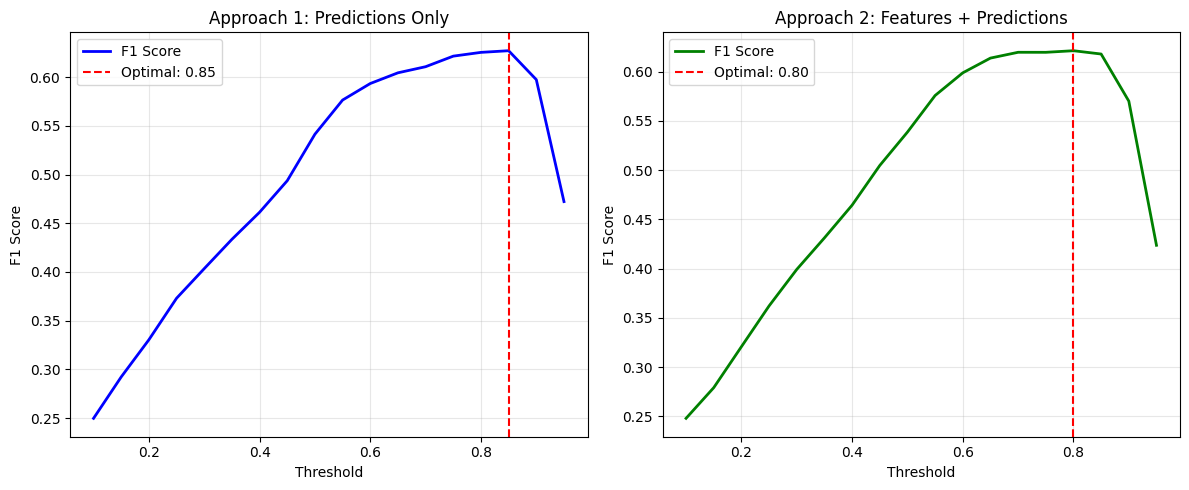


✓ Threshold optimization plot saved: threshold_optimization_comparison.png


In [12]:
# Get predictions for threshold optimization
y_pred_proba_pred = meta_learner_pred.predict_proba(X_train_pred)[:, 1]
y_pred_proba_features = meta_learner_features.predict_proba(X_train_features)[:, 1]

# Test different thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores_pred = []
f1_scores_features = []

for threshold in thresholds:
    # Predictions-based model
    y_pred_thresh_pred = (y_pred_proba_pred >= threshold).astype(int)
    f1_pred = f1_score(y_val, y_pred_thresh_pred)
    f1_scores_pred.append(f1_pred)
    
    # Features-based model
    y_pred_thresh_features = (y_pred_proba_features >= threshold).astype(int)
    f1_features = f1_score(y_val, y_pred_thresh_features)
    f1_scores_features.append(f1_features)

# Find optimal thresholds
optimal_idx_pred = np.argmax(f1_scores_pred)
optimal_threshold_pred = thresholds[optimal_idx_pred]
optimal_f1_pred = f1_scores_pred[optimal_idx_pred]

optimal_idx_features = np.argmax(f1_scores_features)
optimal_threshold_features = thresholds[optimal_idx_features]
optimal_f1_features = f1_scores_features[optimal_idx_features]

print("=" * 60)
print("Threshold Optimization Results")
print("=" * 60)
print(f"\nApproach 1 (Predictions Only):")
print(f"  Optimal Threshold: {optimal_threshold_pred:.2f}")
print(f"  Optimal F1 Score: {optimal_f1_pred:.4f}")

print(f"\nApproach 2 (Features + Predictions):")
print(f"  Optimal Threshold: {optimal_threshold_features:.2f}")
print(f"  Optimal F1 Score: {optimal_f1_features:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(thresholds, f1_scores_pred, 'b-', linewidth=2, label='F1 Score')
plt.axvline(optimal_threshold_pred, color='r', linestyle='--', label=f'Optimal: {optimal_threshold_pred:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Approach 1: Predictions Only')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(thresholds, f1_scores_features, 'g-', linewidth=2, label='F1 Score')
plt.axvline(optimal_threshold_features, color='r', linestyle='--', label=f'Optimal: {optimal_threshold_features:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Approach 2: Features + Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Threshold optimization plot saved: threshold_optimization_comparison.png")

### Step 12: Final Test Set Evaluation - Both Approaches

In [13]:
# Evaluate both models on test set
print("=" * 80)
print("FINAL TEST SET EVALUATION")
print("=" * 80)

# Approach 1: Predictions Only
y_test_pred_proba_pred = meta_learner_pred.predict_proba(X_test_pred)[:, 1]
y_test_pred_pred = (y_test_pred_proba_pred >= optimal_threshold_pred).astype(int)

print("\n" + "=" * 80)
print("APPROACH 1: Predictions Only (10 features)")
print("=" * 80)
print(f"Optimal Threshold: {optimal_threshold_pred:.2f}\n")
print(classification_report(y_test, y_test_pred_pred, target_names=['Legitimate', 'Fraud']))
print("\nConfusion Matrix:")
cm_pred = confusion_matrix(y_test, y_test_pred_pred)
print(cm_pred)
print(f"\nAccuracy: {accuracy_score(y_test, y_test_pred_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_pred):.4f}")

# Approach 2: Features + Predictions
y_test_pred_proba_features = meta_learner_features.predict_proba(X_test_features)[:, 1]
y_test_pred_features = (y_test_pred_proba_features >= optimal_threshold_features).astype(int)

print("\n" + "=" * 80)
print("APPROACH 2: Raw Features + Predictions (102 features) - FOR API DEPLOYMENT")
print("=" * 80)
print(f"Optimal Threshold: {optimal_threshold_features:.2f}\n")
print(classification_report(y_test, y_test_pred_features, target_names=['Legitimate', 'Fraud']))
print("\nConfusion Matrix:")
cm_features = confusion_matrix(y_test, y_test_pred_features)
print(cm_features)
print(f"\nAccuracy: {accuracy_score(y_test, y_test_pred_features):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_features):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_features):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_features):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_features):.4f}")

# Comparison Summary
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON - Test Set")
print("=" * 80)
print(f"{'Metric':<20} {'Predictions Only':<20} {'Features + Pred':<20} {'Improvement'}")
print("=" * 80)

metrics_comparison = {
    'Accuracy': (accuracy_score(y_test, y_test_pred_pred), accuracy_score(y_test, y_test_pred_features)),
    'Precision': (precision_score(y_test, y_test_pred_pred), precision_score(y_test, y_test_pred_features)),
    'Recall': (recall_score(y_test, y_test_pred_pred), recall_score(y_test, y_test_pred_features)),
    'F1-Score': (f1_score(y_test, y_test_pred_pred), f1_score(y_test, y_test_pred_features)),
    'ROC-AUC': (roc_auc_score(y_test, y_test_pred_proba_pred), roc_auc_score(y_test, y_test_pred_proba_features))
}

for metric, (score_pred, score_features) in metrics_comparison.items():
    improvement = ((score_features - score_pred) / score_pred) * 100
    print(f"{metric:<20} {score_pred:<20.4f} {score_features:<20.4f} {improvement:+.2f}%")

print("=" * 80)

FINAL TEST SET EVALUATION

APPROACH 1: Predictions Only (10 features)
Optimal Threshold: 0.85

              precision    recall  f1-score   support

  Legitimate       0.93      0.98      0.95     10471
       Fraud       0.77      0.52      0.62      1593

    accuracy                           0.92     12064
   macro avg       0.85      0.75      0.79     12064
weighted avg       0.91      0.92      0.91     12064


Confusion Matrix:
[[10220   251]
 [  763   830]]

Accuracy: 0.9159
Precision: 0.7678
Recall: 0.5210
F1-Score: 0.6208
ROC-AUC: 0.8691

APPROACH 2: Raw Features + Predictions (102 features) - FOR API DEPLOYMENT
Optimal Threshold: 0.80

              precision    recall  f1-score   support

  Legitimate       0.93      0.97      0.95     10471
       Fraud       0.75      0.53      0.62      1593

    accuracy                           0.91     12064
   macro avg       0.84      0.75      0.79     12064
weighted avg       0.91      0.91      0.91     12064


Confusion Matri

### Step 13: Save Both Models for Deployment

In [14]:
# Save both meta-learners
joblib.dump(meta_learner_pred, 'meta_learner_predictions_only.pkl')
joblib.dump(meta_learner_features, 'meta_learner_features_api.pkl')

# Save optimal thresholds and model info
model_info = {
    'predictions_only': {
        'threshold': float(optimal_threshold_pred),
        'test_f1': float(f1_score(y_test, y_test_pred_pred)),
        'test_roc_auc': float(roc_auc_score(y_test, y_test_pred_proba_pred)),
        'features': 10,
        'feature_names': ['pred_lr', 'pred_rf', 'pred_xgb', 'pred_xgb_smote', 'pred_catboost',
                          'pred_fnn', 'pred_cnn', 'pred_lstm', 'pred_bilstm', 'pred_cnn_bilstm'],
        'deployment': 'ensemble_evaluation'
    },
    'features_api': {
        'threshold': float(optimal_threshold_features),
        'test_f1': float(f1_score(y_test, y_test_pred_features)),
        'test_roc_auc': float(roc_auc_score(y_test, y_test_pred_proba_features)),
        'features': X_train_features.shape[1],
        'feature_names': list(X_train_features.columns),
        'deployment': 'api_production',
        'best_params': grid_search.best_params_
    }
}

import json
with open('meta_learner_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("=" * 60)
print("Models and Configuration Saved")
print("=" * 60)
print("\n✓ Saved Files:")
print("  1. meta_learner_predictions_only.pkl")
print("  2. meta_learner_features_api.pkl (RECOMMENDED FOR API)")
print("  3. meta_learner_info.json")
print("  4. p_features_train.npy")
print("  5. p_features_test.npy")
print("\n✓ Model Information:")
print(f"  Predictions-only model: F1={model_info['predictions_only']['test_f1']:.4f}, Features={model_info['predictions_only']['features']}")
print(f"  Feature-based model: F1={model_info['features_api']['test_f1']:.4f}, Features={model_info['features_api']['features']}")
print("\n✓ Recommendation: Use 'meta_learner_features_api.pkl' for API deployment")

Models and Configuration Saved

✓ Saved Files:
  1. meta_learner_predictions_only.pkl
  2. meta_learner_features_api.pkl (RECOMMENDED FOR API)
  3. meta_learner_info.json
  4. p_features_train.npy
  5. p_features_test.npy

✓ Model Information:
  Predictions-only model: F1=0.6208, Features=10
  Feature-based model: F1=0.6186, Features=102

✓ Recommendation: Use 'meta_learner_features_api.pkl' for API deployment


### Step 14: Create API-Ready Deployment Script

In [15]:
deployment_script = """
import joblib
import json
import numpy as np
import pandas as pd
from pathlib import Path

class HybridFusionAPI:
    '''
    API-Ready Hybrid Fusion Model for Fraud Detection
    
    This model accepts raw transaction features and predicts fraud probability.
    It combines raw features with base model predictions for enhanced accuracy.
    '''
    
    def __init__(self, model_dir='./'):
        self.model_dir = Path(model_dir)
        self.meta_learner = None
        self.config = None
        self.feature_names = None
        self.threshold = None
        
    def load(self):
        '''Load the feature-based meta-learner and configuration'''
        # Load meta-learner
        model_path = self.model_dir / 'meta_learner_features_api.pkl'
        self.meta_learner = joblib.load(model_path)
        
        # Load configuration
        config_path = self.model_dir / 'meta_learner_info.json'
        with open(config_path, 'r') as f:
            self.config = json.load(f)
        
        self.feature_names = self.config['features_api']['feature_names']
        self.threshold = self.config['features_api']['threshold']
        
        print(f"✓ Model loaded successfully")
        print(f"  Features: {len(self.feature_names)}")
        print(f"  Optimal threshold: {self.threshold:.2f}")
        print(f"  Test F1-Score: {self.config['features_api']['test_f1']:.4f}")
        
        return self
    
    def predict_proba(self, X):
        '''
        Get fraud probability for transactions
        
        Parameters:
        -----------
        X : pd.DataFrame or np.ndarray
            Transaction features (must have same features as training data)
            
        Returns:
        --------
        np.ndarray : Fraud probabilities (0-1)
        '''
        if self.meta_learner is None:
            raise ValueError("Model not loaded. Call load() first.")
        
        # Convert to DataFrame if needed
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        
        # Ensure correct feature order
        X = X[self.feature_names]
        
        # Get probabilities
        proba = self.meta_learner.predict_proba(X)[:, 1]
        return proba
    
    def predict(self, X, threshold=None):
        '''
        Predict fraud (binary classification)
        
        Parameters:
        -----------
        X : pd.DataFrame or np.ndarray
            Transaction features
        threshold : float, optional
            Custom threshold (default: optimal threshold from training)
            
        Returns:
        --------
        np.ndarray : Binary predictions (0=Legitimate, 1=Fraud)
        '''
        if threshold is None:
            threshold = self.threshold
        
        proba = self.predict_proba(X)
        predictions = (proba >= threshold).astype(int)
        return predictions
    
    def get_info(self):
        '''Get model information and configuration'''
        if self.config is None:
            raise ValueError("Model not loaded. Call load() first.")
        
        return {
            'model_type': 'Hybrid Fusion (Features + Predictions)',
            'features': len(self.feature_names),
            'threshold': self.threshold,
            'test_f1': self.config['features_api']['test_f1'],
            'test_roc_auc': self.config['features_api']['test_roc_auc'],
            'deployment': self.config['features_api']['deployment'],
            'best_params': self.config['features_api']['best_params']
        }

# Example usage
if __name__ == '__main__':
    # Initialize and load model
    model = HybridFusionAPI(model_dir='./')
    model.load()
    
    # Example: Load test data
    X_test = pd.read_csv('../../data/final_processed_data/X_test_scaled.csv')
    y_test = pd.read_csv('../../data/final_processed_data/y_test.csv').values.ravel()
    
    # Get predictions
    fraud_proba = model.predict_proba(X_test)
    fraud_predictions = model.predict(X_test)
    
    print(f"\\nPredictions: {fraud_predictions.sum()} frauds detected out of {len(fraud_predictions)} transactions")
    print(f"Fraud rate: {fraud_predictions.mean()*100:.2f}%")
    
    # Model info
    info = model.get_info()
    print(f"\\nModel Info:")
    for key, value in info.items():
        print(f"  {key}: {value}")
"""

# Save the deployment script
with open('hybrid_fusion_api.py', 'w') as f:
    f.write(deployment_script)

print("=" * 60)
print("API Deployment Script Created")
print("=" * 60)
print("✓ File: hybrid_fusion_api.py")
print("\nUsage:")
print("  from hybrid_fusion_api import HybridFusionAPI")
print("  model = HybridFusionAPI(model_dir='./')")
print("  model.load()")
print("  predictions = model.predict(transaction_features)")
print("\nFeatures:")
print("  - Accepts raw transaction features (92 features)")
print("  - Automatic feature ordering and validation")
print("  - Configurable threshold")
print("  - Returns fraud probabilities or binary predictions")
print("=" * 60)

API Deployment Script Created
✓ File: hybrid_fusion_api.py

Usage:
  from hybrid_fusion_api import HybridFusionAPI
  model = HybridFusionAPI(model_dir='./')
  model.load()
  predictions = model.predict(transaction_features)

Features:
  - Accepts raw transaction features (92 features)
  - Automatic feature ordering and validation
  - Configurable threshold
  - Returns fraud probabilities or binary predictions
